> **Note**  
> 
> Clustering metric results can vary significantly depending on the structure of the randomly generated data and seeds.  
> 
> We recommend complementing metric-based evaluation with a visual inspection of the clustering results—especially by comparing predicted cluster labels to the ground truth (if available), and considering the presence of anomalies.  
> 
> Assessing both the visual patterns and overall metric trends provides a more comprehensive understanding of clustering performance.
> 
> In this notebook, we aim to show examples where clusters are:
> - Mostly separate
> - Centroid-based
> - Contain known and unknown anomalies
> - Contain known and unknown clusters
> - Include a distinct small cluster that may represent either an unknown class or a small group of anomalies
>
>


# Imports and setup

In [5]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Get the current working directory (where the notebook is running from)
notebook_dir = os.getcwd()
# Go up 1 level to reach the 'clustering' project root
root_path = os.path.abspath(os.path.join(notebook_dir, '../'))
if root_path not in sys.path:
    sys.path.insert(0, root_path)

# Project root resolution
CURRENT_DIR = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
ROOT_PATH = CURRENT_DIR.parent
sys.path.insert(0, str(ROOT_PATH))

In [6]:
# ---------------------------- Module Imports -------------------------------
from clustering_evaluation.dataset_config import dataset_dict
from clustering_evaluation.clustering_methods import (
    kmeans_clustering, meanshift_clustering, dbscan_clustering,
    agglomerative_clustering, gmm_clustering, spectral_clustering,
    constrained_kmeans_clustering, copk_means_clustering, hdbscan_clustering, 
    seeded_k_means_clustering, novel_clustering, dec_clustering,
    run_and_time_clusterings,
)
from utilities.plotting import (
    plot_clusters, plot_enabled_clusterings, 
    plot_confusion_matrices_for_clustering,
)
from utilities.cluster_utilities import save_df, combine_results
from utilities.evaluation_metrics import (
    compute_accuracy, compute_purity, compute_homogeneity, compute_ari,
    compute_completeness, compute_v_measure, compute_nmi, compute_fmi,
    compute_silhouette, compute_davies_bouldin, compute_calinski_harabasz,
    evaluate_clustering_metrics,
)
from utilities.generate_load_data import load_dataset

## Dataset configurations

In [7]:
# Define dataset name, note all features must be numeric
dataset_name = "2d_gauss"  # Options: "1d_simple", 
#                              "1d_gauss", 
#                              "2d_gauss", 

## Generate or read data from file

In [8]:
df, num_clusters, plot_title, feature_columns = load_dataset(
        dataset_name,
        random_seed=43,
        k=8,
        percent_labelled=0.01,
        standardise=False,
    )

print(f"Number of examples in dataset: {df.shape[0]}")
print(f"Number of features in dataset: {len(feature_columns)}")
print(f"Feature columns: {feature_columns}")
df

Number of examples in dataset: 10300
Number of features in dataset: 2
Feature columns: ['f0', 'f1']


,f0,f1,y_true,y_live
0,-3.577115,7.409740,2,-1
1,-7.496777,2.719674,0,-1
2,-3.554719,7.132534,2,-1
3,-6.976751,5.938354,4,-1
4,-5.527477,-8.477739,6,-1
...,...,...,...,...
10295,-6.411710,10.164349,-1,-1
10296,20.716804,-3.802275,-1,-1
10297,22.464351,5.458152,-1,-1
10298,9.323011,22.703861,-1,-1


## Plot the data with the true labels

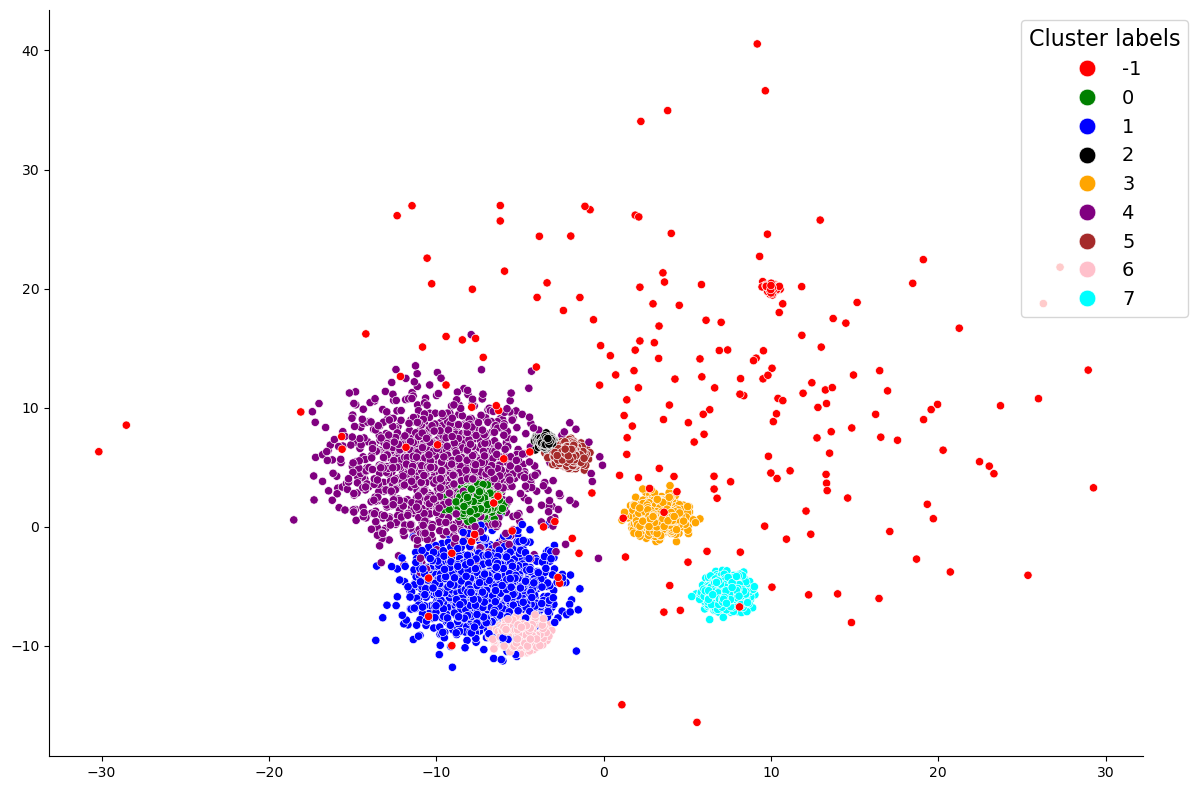

In [12]:
# %% Plot dataset (anomaly labels are -1 and these examples are coloured in red)
plot_clusters(df, feature_columns, label_column='y_true', title=plot_title, show_seeds_only=False);

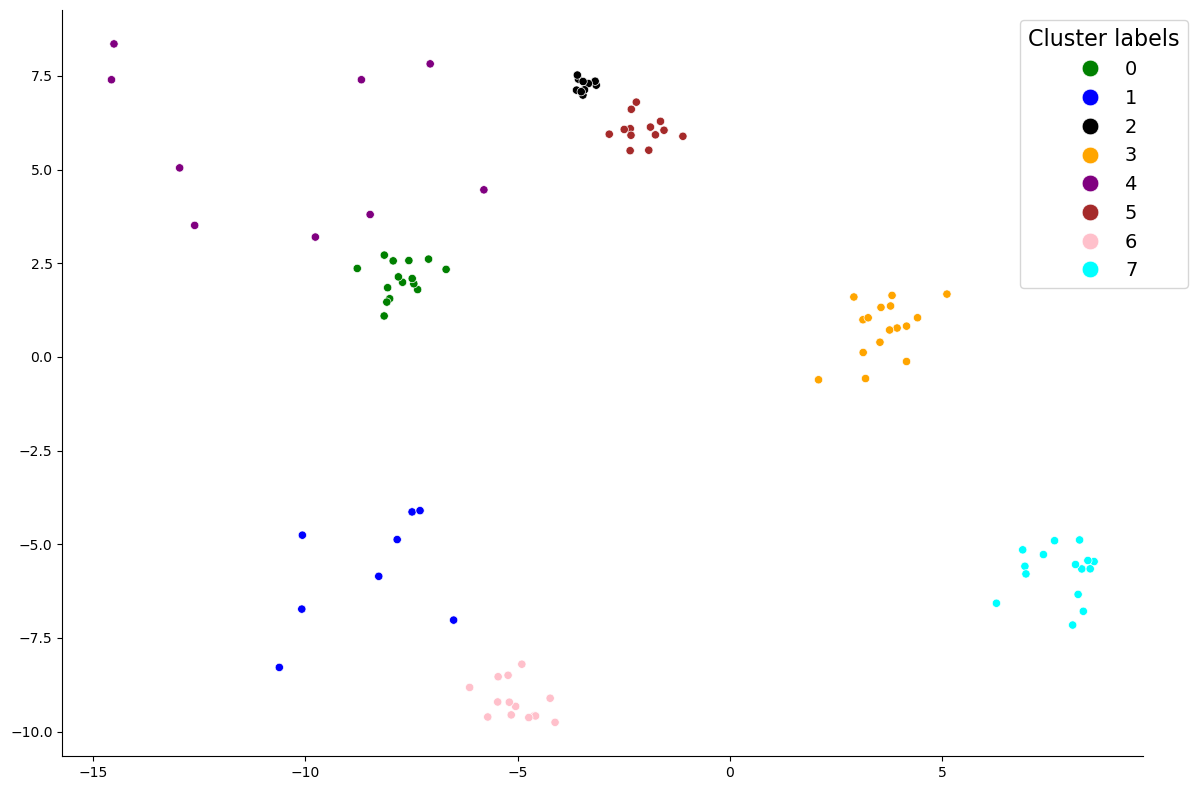

In [14]:
# %% Plot dataset seeds (anomaly labels are -1 and these examples are coloured in red)
plot_clusters(df, feature_columns, label_column='y_live', 
              title=dataset_name + ' (seeds only)', show_seeds_only=True);

# Run novel clustering method

              f0         f1  y_true  y_live  novel_method
0      -3.577115   7.409740       2      -1             2
1      -7.496777   2.719674       0      -1             0
2      -3.554719   7.132534       2      -1             2
3      -6.976751   5.938354       4      -1             4
4      -5.527477  -8.477739       6      -1             6
...          ...        ...     ...     ...           ...
10295  -6.411710  10.164349      -1      -1             4
10296  20.716804  -3.802275      -1      -1            -1
10297  22.464351   5.458152      -1      -1            -1
10298   9.323011  22.703861      -1      -1            -1
10299   9.999425  20.259153      -1      -1            -1

[10300 rows x 5 columns]


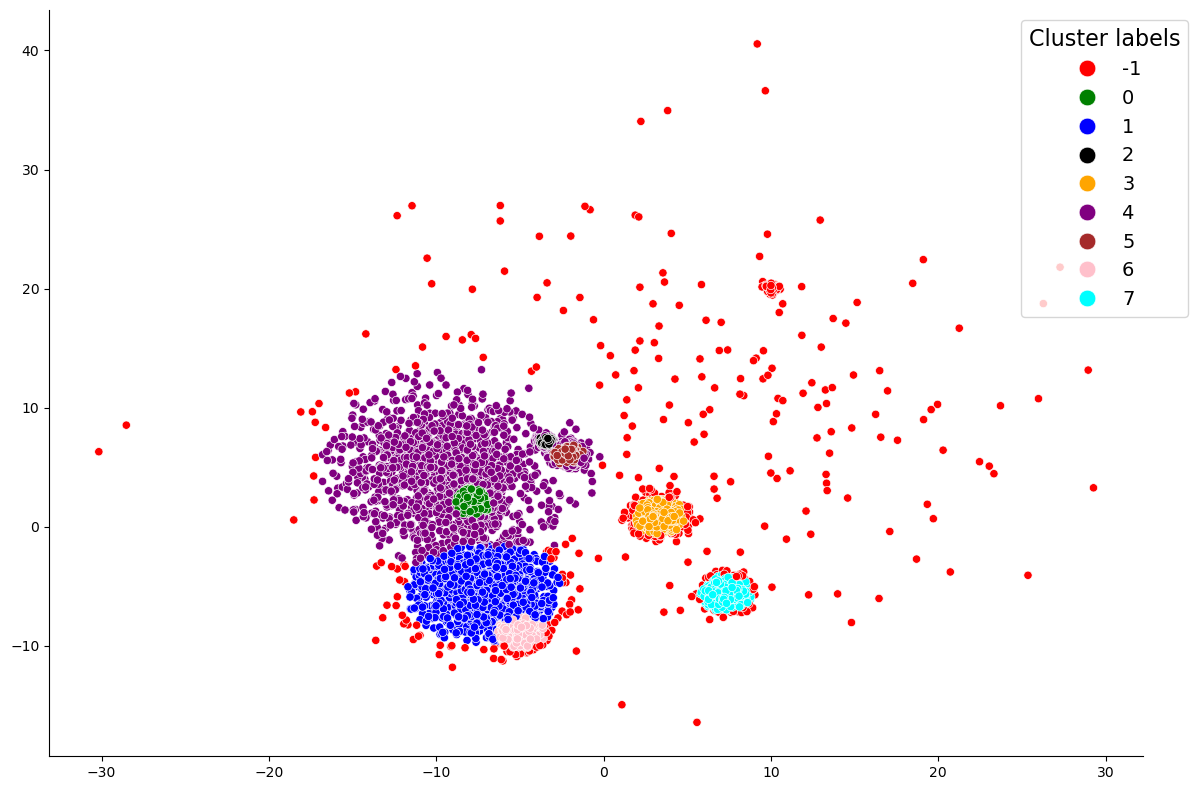

In [15]:
# run the novel clustering algorithm
# ensure dataframe has 'y_live' column of partially labelled data for semi-supervised clustering
df_c = df.copy()
df['novel_method'] = novel_clustering(df_c, feature_columns, seeds='y_live')['novel_method']
print(df)
plot_clusters(df, feature_columns, label_column='novel_method', 
              title="Novel Clustering Results: " + dataset_name, show_seeds_only=False);

# Seeded k-means method

              f0         f1  y_true  y_live  novel_method  SeededKMeans
0      -3.577115   7.409740       2      -1             2             2
1      -7.496777   2.719674       0      -1             0             0
2      -3.554719   7.132534       2      -1             2             2
3      -6.976751   5.938354       4      -1             4             0
4      -5.527477  -8.477739       6      -1             6             6
...          ...        ...     ...     ...           ...           ...
10295  -6.411710  10.164349      -1      -1             4             2
10296  20.716804  -3.802275      -1      -1            -1             7
10297  22.464351   5.458152      -1      -1            -1            -1
10298   9.323011  22.703861      -1      -1            -1            -1
10299   9.999425  20.259153      -1      -1            -1            -1

[10300 rows x 6 columns]


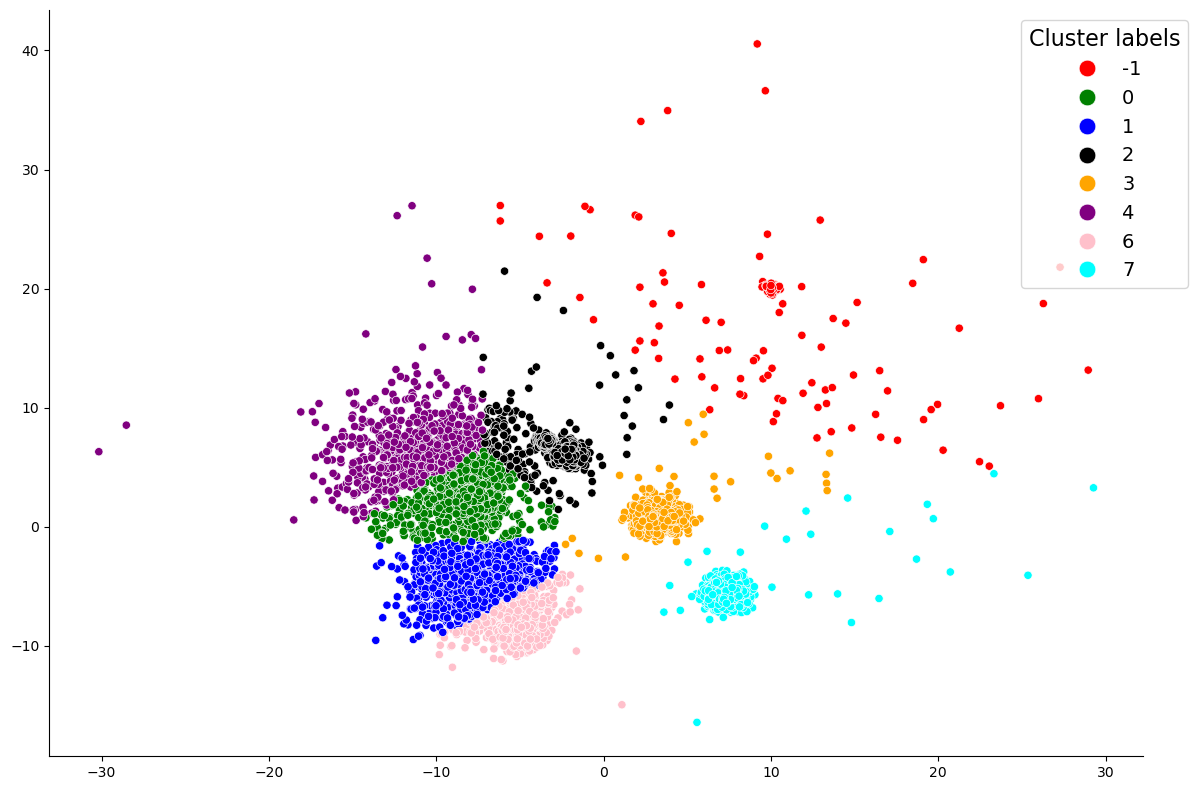

In [16]:
df_c = df.copy()
df_seeded_k_means = seeded_k_means_clustering(df_c, feature_columns, target_column='y_true', 
                                              seeds='y_live', n_clusters=num_clusters, 
                                              random_state=0, remap_labels=True)
df['SeededKMeans'] = df_seeded_k_means['SeededKMeans']
print(df_seeded_k_means)
plot_clusters(df_seeded_k_means, feature_columns, label_column='SeededKMeans', 
              title="SeededKMeans Clustering Results: " + dataset_name, show_seeds_only=False);

# K-means clustering method

              f0         f1  y_true  y_live  novel_method  SeededKMeans  \
0      -3.577115   7.409740       2      -1             2             2   
1      -7.496777   2.719674       0      -1             0             0   
2      -3.554719   7.132534       2      -1             2             2   
3      -6.976751   5.938354       4      -1             4             0   
4      -5.527477  -8.477739       6      -1             6             6   
...          ...        ...     ...     ...           ...           ...   
10295  -6.411710  10.164349      -1      -1             4             2   
10296  20.716804  -3.802275      -1      -1            -1             7   
10297  22.464351   5.458152      -1      -1            -1            -1   
10298   9.323011  22.703861      -1      -1            -1            -1   
10299   9.999425  20.259153      -1      -1            -1            -1   

       KMeans  
0           2  
1           0  
2           2  
3           1  
4           6  
...

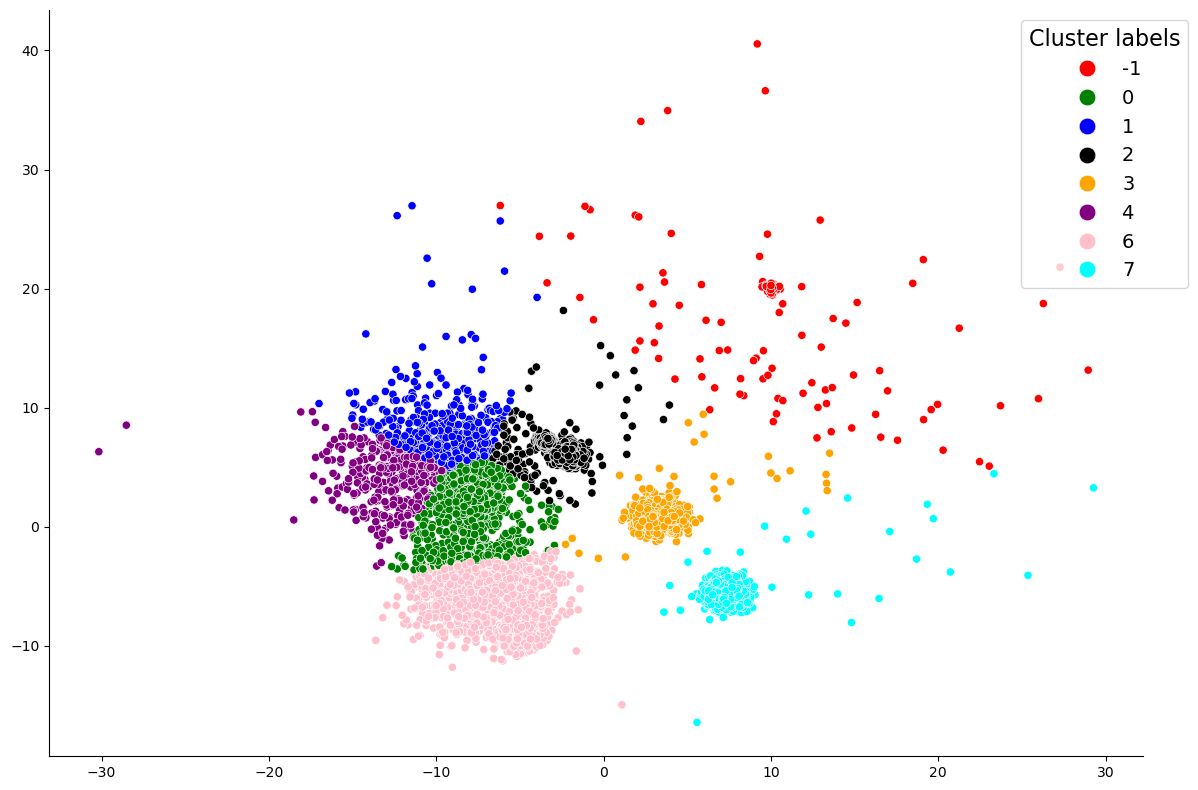

In [18]:
df_c = df.copy()
df_k_means = kmeans_clustering(df_c, feature_columns, target_column='y_true', 
                               n_clusters=num_clusters, random_state=0, remap_labels=True)
df['KMeans'] = df_k_means['KMeans']
print(df)
plot_clusters(df, feature_columns, label_column='KMeans', 
              title="KMeans Clustering Results: " + dataset_name, show_seeds_only=False);

# DBSCAN clustering method

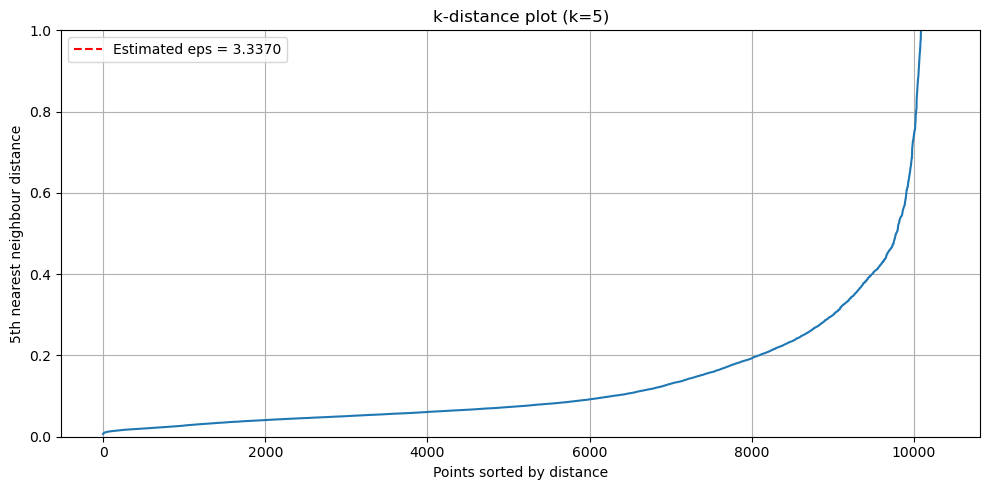

Estimated eps: 3.3370490923460903


In [19]:
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

def estimate_eps(df, feature_columns, k=5, zoom_ymax=2.0, detect_knee=True):
    """
    Estimate a good eps value for DBSCAN using the k-distance method.

    Parameters:
    - df: DataFrame containing your data.
    - feature_columns: list of feature column names (1D or 2D).
    - k: number of neighbours (min_samples = k).
    - zoom_ymax: max Y limit to zoom into the k-distance plot.
    - detect_knee: whether to automatically find the elbow point.

    Returns:
    - eps: Estimated eps value.
    """

    X = df[feature_columns].values

    # Fit NearestNeighbors
    neigh = NearestNeighbors(n_neighbors=k)
    nbrs = neigh.fit(X)
    distances, _ = nbrs.kneighbors(X)

    # Sort the k-th distance (k-1 index since indexing starts at 0)
    k_distances = np.sort(distances[:, k - 1])

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(k_distances)
    plt.ylim(0, zoom_ymax)
    plt.title(f'k-distance plot (k={k})')
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'{k}th nearest neighbour distance')

    eps = None
    if detect_knee:
        knee_locator = KneeLocator(
            range(len(k_distances)),
            k_distances,
            curve='convex',
            direction='increasing'
        )
        eps = k_distances[knee_locator.knee] if knee_locator.knee is not None else None
        if eps:
            plt.axhline(y=eps, color='red', linestyle='--', label=f"Estimated eps = {eps:.4f}")
            plt.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return eps

eps = estimate_eps(df, feature_columns=feature_columns, k=5, zoom_ymax=1.0, detect_knee=True)
print(f"Estimated eps: {eps}")


              f0         f1  y_true  y_live  novel_method  SeededKMeans  \
0      -3.577115   7.409740       2      -1             2             2   
1      -7.496777   2.719674       0      -1             0             0   
2      -3.554719   7.132534       2      -1             2             2   
3      -6.976751   5.938354       4      -1             4             0   
4      -5.527477  -8.477739       6      -1             6             6   
...          ...        ...     ...     ...           ...           ...   
10295  -6.411710  10.164349      -1      -1             4             2   
10296  20.716804  -3.802275      -1      -1            -1             7   
10297  22.464351   5.458152      -1      -1            -1            -1   
10298   9.323011  22.703861      -1      -1            -1            -1   
10299   9.999425  20.259153      -1      -1            -1            -1   

       KMeans  DBSCAN  
0           2       0  
1           0       1  
2           2       0  
3  

/Users/nassirmohammad/projects/clustering/utilities/plotting.py:136: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


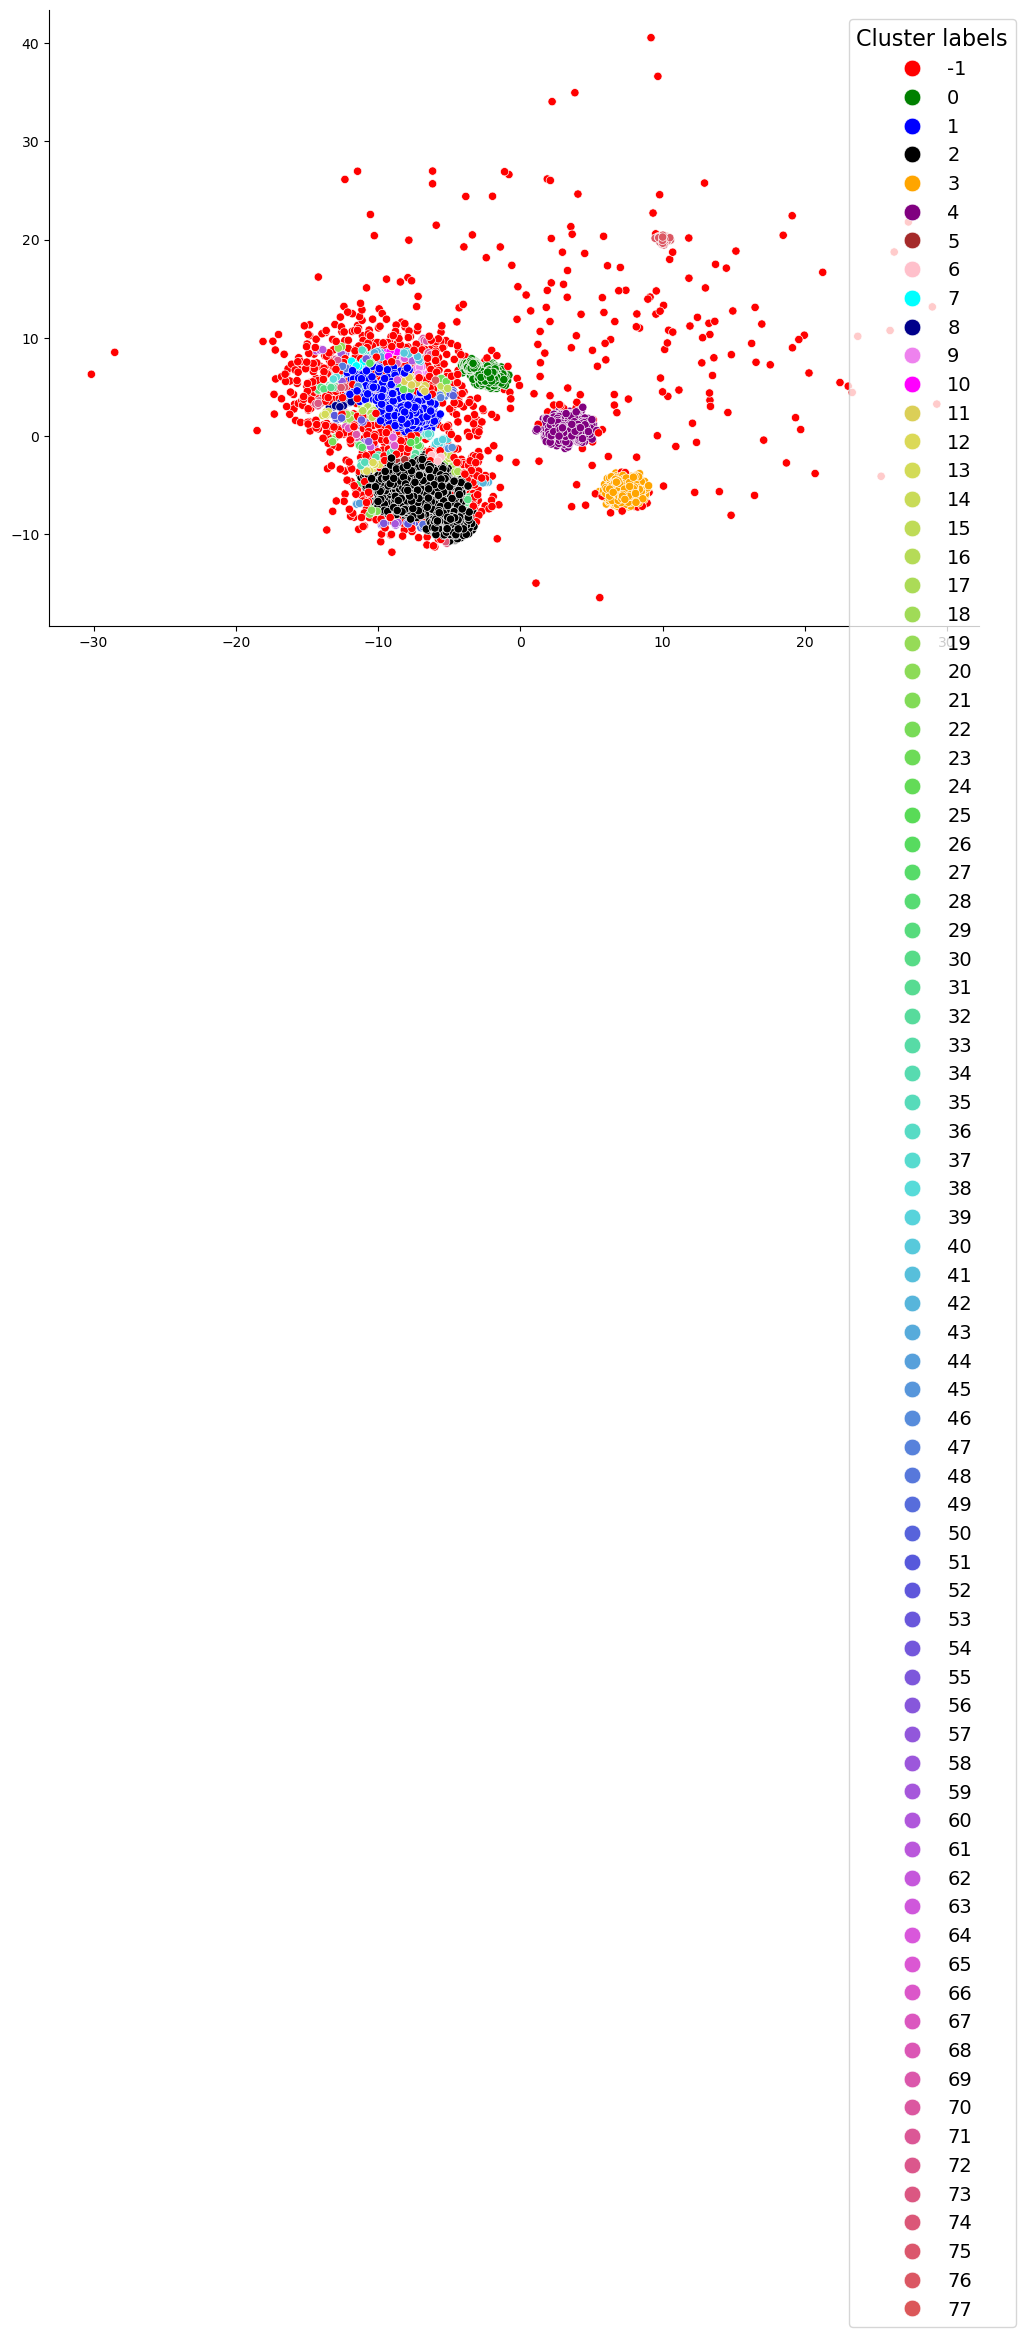

In [21]:
# eps selected as according to paper visually to be 0.1
# knee locator suggests 1
# min_samples = number_of_dimensions + 1 = 4
# sensitive to parameters eps and min_samples
df_c = df.copy()
df_dbscan = dbscan_clustering(df_c, feature_columns, target_column='y_true', 
                              eps=0.3, min_samples=4, remap_labels=False)
df['DBSCAN'] = df_dbscan['DBSCAN']
print(df_dbscan)
plot_clusters(df_dbscan, feature_columns, label_column='DBSCAN', 
              title="DBSCAN Clustering Results: " + dataset_name, 
              show_seeds_only=False);

# Clustering Evaluation Metrics

In [23]:
# Automatically determine enabled clustering methods from flags
clustering_methods = ['novel_method', 'SeededKMeans', 'KMeans', 'DBSCAN']

# Define clustering quality metrics requiring ground truth
supervised_metrics = {
    # 'Accuracy': compute_accuracy,
    'Purity': compute_purity,
    # 'Homogeneity': compute_homogeneity,
    # 'Completeness': compute_completeness,
    'V-Measure': compute_v_measure,
    'NMI': compute_nmi,
    'ARI': compute_ari,
    'FMI': compute_fmi,
}

# Compute all metrics in one nested dictionary: {algorithm: {metric: value}}
supervised_results = {
    method: {
        metric: func(df, true_col='y_true', pred_col=method)
        for metric, func in supervised_metrics.items()
    }
    for method in clustering_methods
}

# Convert to DataFrame
supervised_metrics_df = pd.DataFrame.from_dict(supervised_results, orient='index')

# Move algorithm names to a column
supervised_metrics_df.reset_index(inplace=True)
supervised_metrics_df.rename(columns={'index': 'Algorithm'}, inplace=True)

# Add dataset name
supervised_metrics_df['Dataset'] = dataset_name

# Output and save
print("\nSupervised Clustering Metrics:")
metric_cols = list(supervised_metrics.keys())

styled_df = (
    supervised_metrics_df.style
    .highlight_max(subset=metric_cols, axis=0, props='font-weight: bold;')
    .background_gradient(subset=metric_cols, cmap='RdYlGn', axis=0)
    .format(precision=4)
)

styled_df


Supervised Clustering Metrics:


,Algorithm,Purity,V-Measure,NMI,ARI,FMI,Dataset
0,novel_method,0.9097,0.8519,0.8519,0.8194,0.8407,2d_gauss
1,SeededKMeans,0.7778,0.8265,0.8265,0.7020,0.7516,2d_gauss
2,KMeans,0.6968,0.7955,0.7955,0.6437,0.7108,2d_gauss
3,DBSCAN,0.7009,0.7697,0.7697,0.6539,0.7124,2d_gauss
